In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [7]:
df = pd.read_csv(r'Diabetes Dataset/User_Oriented_Dataset.csv')
df.head()

,Age,gender,ethnicity,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,diabetes_stage
0,58,Male,Asian,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,Type 2
1,52,Female,White,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,No Diabetes
2,60,Male,Hispanic,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,Type 2
3,74,Female,Black,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,Type 2
4,46,Male,White,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,Type 2


In [8]:
# User Oriented Model Features

features = ['Age', 'gender', 'ethnicity', 'smoking_status', \
        'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', \
        'sleep_hours_per_day', 'screen_time_hours_per_day', \
        'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', \
        'bmi', 'waist_to_hip_ratio']


# Select features and target variable
X = df[features]
y = df['diabetes_stage'] 

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)

numeric_features = [
    'Age',
    'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'bmi',
    'waist_to_hip_ratio'
]

categorical_features = [
    'gender',
    'ethnicity',
    'smoking_status',
    'family_history_diabetes',
    'hypertension_history',
    'cardiovascular_history'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [9]:
# Creating the Model

classes = ['No Diabetes', 'Pre Diabetes', 'Diabetes 1', 'Diabetes 2', 'Gestational']

def build_patient_model():
    model = models.Sequential([
        # Input layer
        layers.Dense(64, activation='relu', input_shape=(x_train_processed.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Hidden layers
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(5, activation='softmax')
    ])
    return model

# Initialize Patient-side Model
patient_model = build_patient_model()

patient_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Implement Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

class_weights_dict = dict(enumerate(class_weights))

# Train the model
history = patient_model.fit(
    x_train_processed, y_train_encoded,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=(x_test_processed, y_test_encoded),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)


c:\Users\Sydney\Tensorflow\Keras-Diabetes\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2349 - loss: 1.7414 - val_accuracy: 0.2715 - val_loss: 1.5986
Epoch 2/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2913 - loss: 1.4447 - val_accuracy: 0.3262 - val_loss: 1.4546
Epoch 3/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3156 - loss: 1.3818 - val_accuracy: 0.3200 - val_loss: 1.4628
Epoch 4/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3198 - loss: 1.3295 - val_accuracy: 0.3255 - val_loss: 1.4273
Epoch 5/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3357 - loss: 1.3071 - val_accuracy: 0.3251 - val_loss: 1.4232
Epoch 6/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3309 - loss: 1.2634 - val_accuracy: 0.3431 - val_loss: 1.3406
Epoch 7/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3339 - loss: 1.2624 - val_accuracy: 0.3422 - val_loss: 1.3766
Epoch 8/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3355 - loss: 1.2526 - 

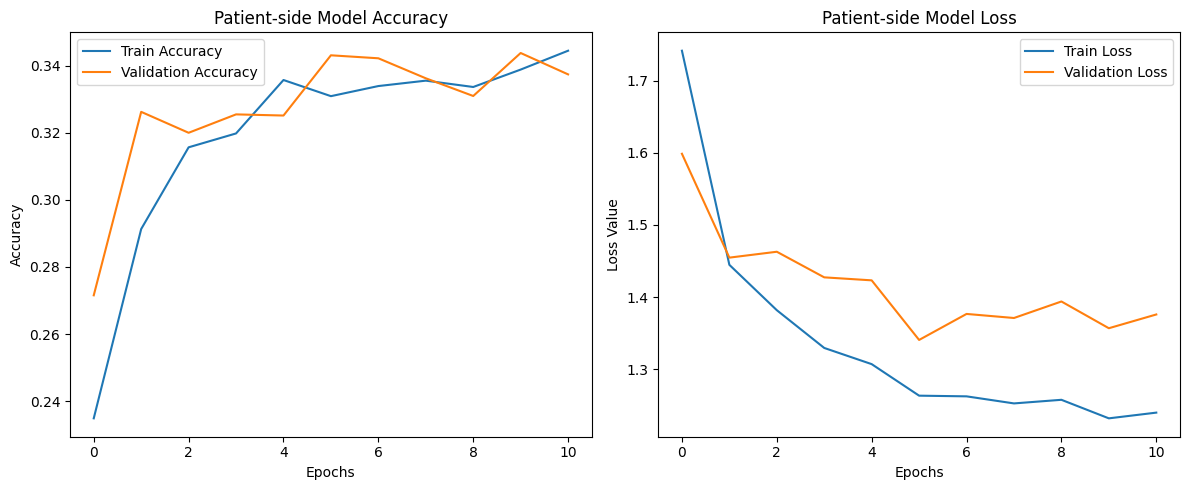

In [10]:
# Visualize Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Patient-side Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Patient-side Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.tight_layout()
plt.show()